In [1]:
import numpy as np
from scipy import fft
import h5py
import os
import csv

RGBs = ['r', 'g', 'b']

In [2]:
from ImgProcess import *     # import all functions from ../Codes/ImgProcessing.py
from KSVD import *              # import all functions from ../Codes/KSVD.py

In [3]:
def DiceLearn(img, size, sparsity, max_iter=10, overlapping=2, mD=None):
    patches, locs, dcs = Img2patch(img, size, overlapping)
    if mD is None:
        mD = fft.dct(np.eye(2 * size**2), norm='ortho')[: size**2]  # initial dictionary
    mD, mX = KSVD(patches, mD, sparsity, max_iter)              # learn the dictionary
    img_learned = Img2patch(mD@mX, locs, dcs, inv=True)         # reconstruct the image
    return img_learned, mD


def MSR(img, img_denoised):
    return np.sum((img - img_denoised)**2) / img.size


def PSNR(img, img_denoised):
    return 10 * np.log10(1 / MSR(img, img_denoised))

# Task 1. 灰色图像的字典学习算法

使用 K-SVD 算法对灰度图像进行字典学习. 

In [4]:
# read the gray scale images
path = '../Images/'
imgs_gray = {}
for file in [file for file in os.listdir(path) if file.endswith('.png')]:
    imgs_gray[file] = plt.imread(path + file)

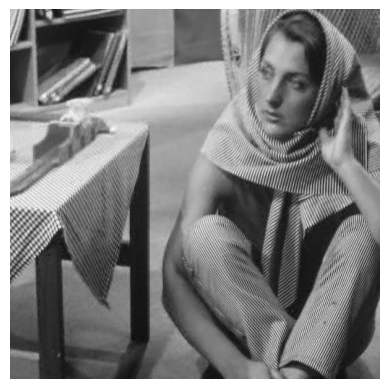

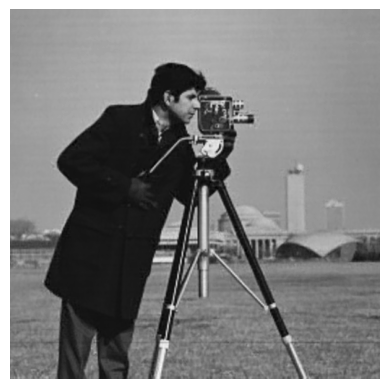

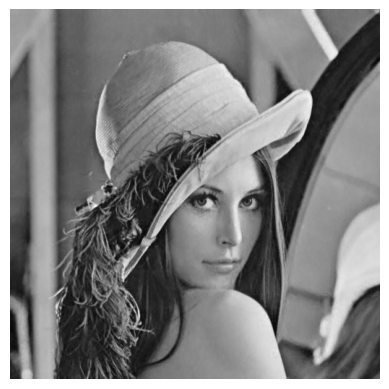

In [5]:
for img_name in list(imgs_gray.keys()):
    img = imgs_gray[img_name]
    size = 16
    img_learned, mD = DiceLearn(img, size, 8, 10)
    
    path = '../results/' + img_name[:-4] + '.csv'
    with open(path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([img_name, f'patch size = {size}'])
        writer.writerows(mD)
        writer.writerow([''])
    
    Show(img_learned)

# Task 2. 彩色图像的字典学习算法

In [6]:
path = '../Images/McM images/'
# read the color images
imgs_clear = {}
for file in [file for file in os.listdir(path) if file.endswith('.tif')]:
    _img = plt.imread(path + file)    # extract the color channels
    imgs_clear[file] = [_img[:,:,0], _img[:,:,1], _img[:,:,2]]

# read the noisy color images
imgs_noise = {}
for file in [file for file in os.listdir(path) if file.endswith('.mat')]:
    _img = h5py.File(path + file)    # extract the color channels
    imgs_noise[file] = [_.T for _ in _img['u_n']]

In [7]:
img = imgs_clear['McM01.tif']
img_noise = imgs_noise['McM01_noise.mat']

In [8]:
img_learned = []
dicts = {}
for i, color in enumerate(RGBs):
    channel = img[i]
    size = 16
    channel_learned, mD = DiceLearn(channel, size, 8, 10)

    img_learned.append(channel_learned)
    dicts[color] = mD

# Task 3. 图像去噪

In [9]:
with open('../results/psnr.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image', 'r', 'g', 'b'])

In [10]:
img_denoised = []

for i, color in enumerate(RGBs):
    mD = dicts[color]
    channel_noise = img_noise[i]

    size = 16
    channel_denoised, _ = DiceLearn(channel_noise, size, 4, max_iter=1, mD=mD)
    img_denoised.append(channel_denoised)

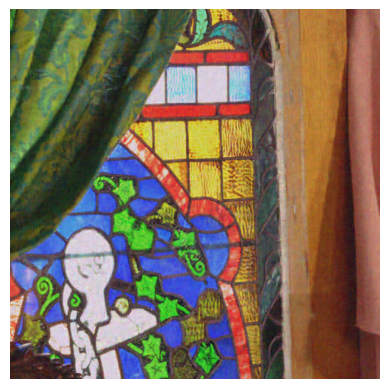

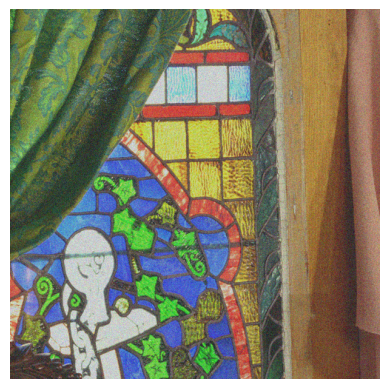

In [11]:
Show(*img_denoised, cmap='rgb')
Show(*img_noise, cmap='rgb')

In [12]:
psnr = {}
for i, color in enumerate(RGBs):
    channel = img[i] / 255
    channel_denoised = img_denoised[i]
    channel_denoised = (channel_denoised - channel_denoised.min()) / (channel_denoised.max() - channel_denoised.min())

    psnr[color] = PSNR(channel, channel_denoised)

with open('../results/psnr.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['McM01', psnr['r'], psnr['g'], psnr['b']])